In [1]:
%matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

<module 'libs.models' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy  as np
import math
import matplotlib.pyplot as plt

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union

import torch.nn as nn
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

In [3]:
df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['bid','ask'] + [params.label_col]]
    
df_feat_sel

,rsi_14,minus_di_15,eng_adx,eng_atr_div,adx_14,sma_100,vol_spike_14,macd_line_12_26_9,sma_20,bid,ask,signal
2004-01-02 13:09:00,0.00000,0.000000,0.000000,0.000279,0.625459,0.00000,0.528843,0.00000,0.00000,0.763664,0.764807,0.021536
2004-01-02 13:10:00,0.00000,0.000000,0.000000,0.000310,0.625379,0.00000,0.528775,0.00000,0.00000,0.763647,0.764790,0.023284
2004-01-02 13:11:00,0.00000,0.000000,0.000000,0.000341,0.625318,0.00000,0.528707,0.00000,0.00000,0.763631,0.764773,0.025175
2004-01-02 13:12:00,0.00000,0.000000,0.000000,0.000341,0.625263,0.00000,0.528641,0.00000,0.00000,0.763614,0.764757,0.027222
2004-01-02 13:13:00,0.00000,0.000000,0.000000,0.000341,0.625227,0.00000,0.528573,0.00000,0.00000,0.763597,0.764740,0.029436
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.67217,0.024691,0.023121,0.024910,0.635234,0.73661,0.541606,0.36312,0.66709,196.667400,196.962600,0.684908
2025-06-18 20:57:00,0.61669,0.024691,0.023121,0.025902,0.629672,0.58962,0.542649,0.34721,0.61512,196.527500,196.822500,0.612206
2025-06-18 20:58:00,0.61473,0.030864,0.023121,0.025499,0.628744,0.58091,0.545497,0.33627,0.61329,196.522500,196.817500,0.610468
2025-06-18 20:59:00,0.47540,0.030864,0.023121,0.031509,0.616953,0.17135,0.538547,0.29058,0.48143,196.092800,196.387200,0.477090


In [4]:
# Build LSTM input tensors (disk-backed memmaps)
X, y_sig, y_ret, raw_close, raw_bid, raw_ask, end_times = models.build_lstm_tensors(
    df            = df_feat_sel,
    sess_start    = params.sess_start_pred_tick 
)

# quick shapes
print("Shapes:")
print("  X         =", X.shape,    "(samples, look_back, features)")
print("  y_sig     =", y_sig.shape, "(samples,)")
print("  y_ret     =", y_ret.shape, "(samples,)")
print("  raw_close =", raw_close.shape)
print("  raw_bid   =", raw_bid.shape)
print("  raw_ask   =", raw_ask.shape)
print("  end_times =", end_times.shape)


Inside build_lstm_tensors, using: ['rsi_14', 'minus_di_15', 'eng_adx', 'eng_atr_div', 'adx_14', 'sma_100', 'vol_spike_14', 'macd_line_12_26_9', 'sma_20']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Shapes:
  X         = torch.Size([2419779, 60, 9]) (samples, look_back, features)
  y_sig     = torch.Size([2419779]) (samples,)
  y_ret     = torch.Size([2419779]) (samples,)
  raw_close = torch.Size([2419779])
  raw_bid   = torch.Size([2419779])
  raw_ask   = torch.Size([2419779])
  end_times = (2419779,)


In [5]:
# Split into train/val/test by calendar day
(
(X_tr,  y_sig_tr,  y_ret_tr),
(X_val, y_sig_val, y_ret_val),
(X_te,  y_sig_te,  y_ret_te,  raw_close_te, raw_bid_te, raw_ask_te),
samples_per_day,
day_id_tr, day_id_val, day_id_te
) = models.chronological_split(
    X, y_sig, y_ret,
    raw_close, raw_bid, raw_ask,
    end_times   = end_times,
    train_prop  = params.train_prop,
    val_prop    = params.val_prop,
    train_batch = params.hparams['TRAIN_BATCH']
)

# Print shapes of all tensors
print("Shapes:")
print("  X_tr  =", X_tr.shape)
print("  y_sig_tr, y_ret_tr =", y_sig_tr.shape, y_ret_tr.shape)
print("  X_val =", X_val.shape)
print("  y_sig_val, y_ret_val =", y_sig_val.shape, y_ret_val.shape)
print("  X_te  =", X_te.shape)
print("  y_sig_te, y_ret_te =", y_sig_te.shape, y_ret_te.shape)


Shapes:
  X_tr  = torch.Size([1716386, 60, 9])
  y_sig_tr, y_ret_tr = torch.Size([1716386]) torch.Size([1716386])
  X_val = torch.Size([338701, 60, 9])
  y_sig_val, y_ret_val = torch.Size([338701]) torch.Size([338701])
  X_te  = torch.Size([364692, 60, 9])
  y_sig_te, y_ret_te = torch.Size([364692]) torch.Size([364692])


In [6]:
# carve `end_times` into the same three splits:
n_tr  = day_id_tr .shape[0] 
n_val = day_id_val.shape[0]
i_tr  = n_tr
i_val = n_tr + n_val

end_times_tr  = end_times[:i_tr]
end_times_val = end_times[i_tr:i_val]
end_times_te  = end_times[i_val:]

# -----------------------------------------------------------------------------
#  Build DataLoaders over calendar‐days
# -----------------------------------------------------------------------------
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # train split:   
    X_tr,            y_sig_tr,     y_ret_tr,   end_times_tr,
    # val split:
    X_val,           y_sig_val,    y_ret_val,  end_times_val,
    # test split + raw‐prices
    X_te,            y_sig_te,     y_ret_te,   end_times_te,
    raw_close_te, raw_bid_te, raw_ask_te,
    
    sess_start_time       = params.sess_start_pred_tick,
    signal_thresh         = params.best_optuna_params["buy_threshold"],
    return_thresh         = 0.01,  # flat‐zone threshold for returns (to tune)
    train_batch           = params.hparams["TRAIN_BATCH"],
    train_workers         = params.hparams["NUM_WORKERS"],
    train_prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"]
)

print(f"Days  → train={len(train_loader.dataset)}, val={len(val_loader.dataset)}, test={len(test_loader.dataset)}")
print(f"Batches → train={len(train_loader)},   val={len(val_loader)},   test={len(test_loader)}")

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Days  → train=3840, val=751, test=809
Batches → train=60,   val=751,   test=809


In [7]:
# -----------------------------------------------------------------------------
# Instantiate the stateful DualMemoryLSTM & move to device
# -----------------------------------------------------------------------------
model = models.DualMemoryLSTM(
    n_feats        = X.shape[-1],                          
    short_units    = params.hparams['SHORT_UNITS'],    
    long_units     = params.hparams['LONG_UNITS'],     
    dropout_short  = params.hparams['DROPOUT_SHORT'],  
    dropout_long   = params.hparams['DROPOUT_LONG'],   
    att_heads      = params.hparams['ATT_HEADS'],
    att_drop       = params.hparams['ATT_DROPOUT']
)
model.to(params.device)  

model

DualMemoryLSTM(
  (conv): Conv1d(9, 9, kernel_size=(3,), stride=(1,), padding=(1,))
  (short_lstm): LSTM(9, 48, batch_first=True, bidirectional=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
  )
  (do_short): Dropout(p=0.15, inplace=False)
  (ln_short): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(96, 64, batch_first=True, bidirectional=True)
  (do_long): Dropout(p=0.15, inplace=False)
  (ln_long): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=128, out_features=1, bias=True)
  (cls_head): Linear(in_features=128, out_features=1, bias=True)
  (cls_ter): Linear(in_features=128, out_features=3, bias=True)
)

In [8]:
# -----------------------------------------------------------------------------
# Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm
# -----------------------------------------------------------------------------
optimizer, plateau_sched, cosine_sched, scaler, clipnorm = models.make_optimizer_and_scheduler(
    model,
    initial_lr        = params.hparams['INITIAL_LR'],       
    weight_decay      = params.hparams['WEIGHT_DECAY'],     
    clipnorm          = params.hparams['CLIPNORM']   
)

optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 7e-05
    lr: 7e-05
    maximize: False
    weight_decay: 0.001
)

In [9]:
# -----------------------------------------------------------------------------
# Helper: extract the true “signal” values from any loader into a flat array
# -----------------------------------------------------------------------------
def extract_y(loader):
    return np.concatenate([batch[1].cpu().numpy().ravel() for batch in loader])

# Pull out train & validation targets
y_train = extract_y(train_loader)
y_val   = extract_y(val_loader)

# -----------------------------------------------------------------------------
# 1) Zero‐forecast baseline RMSE (predict 0 always)
#    RMSE_zero = √(mean(y²))
# -----------------------------------------------------------------------------
rmse_zero_train = np.sqrt(np.mean(y_train**2))
rmse_zero_val   = np.sqrt(np.mean(y_val**2))
print(f"Zero‐forecast RMSE (predict 0): train = {rmse_zero_train:.6f},  val = {rmse_zero_val:.6f}\n")

# -----------------------------------------------------------------------------
# 2) Compute mean, variance & std for train/validation targets
#    and derive the mean‐predictor baseline (R² = 0)
# -----------------------------------------------------------------------------
for split, y in [("Train", y_train), ("Validation", y_val)]:
    mean_y    = y.mean()
    std_y     = y.std(ddof=0)     # population std = √variance
    var_y     = std_y**2
    rmse_mean = std_y            # RMSE_baseline = std(target)

    print(f"{split} target stats:")
    print(f"  mean = {mean_y:.4f},  var = {var_y:.4f},  std = {std_y:.4f}")
    print(f"{split} mean‐predictor baseline:")
    print(f"  RMSE_baseline = {rmse_mean:.6f}")
    print("  R²_baseline   = 0.00\n")

    if split == "Validation":
        rmse_mean_val = rmse_mean # used afterwards for the final reporting
        


Zero‐forecast RMSE (predict 0): train = 0.404006,  val = 0.409382

Train target stats:
  mean = 0.2811,  var = 0.0842,  std = 0.2901
Train mean‐predictor baseline:
  RMSE_baseline = 0.290139
  R²_baseline   = 0.00

Validation target stats:
  mean = 0.2919,  var = 0.0824,  std = 0.2870
Validation mean‐predictor baseline:
  RMSE_baseline = 0.287012
  R²_baseline   = 0.00



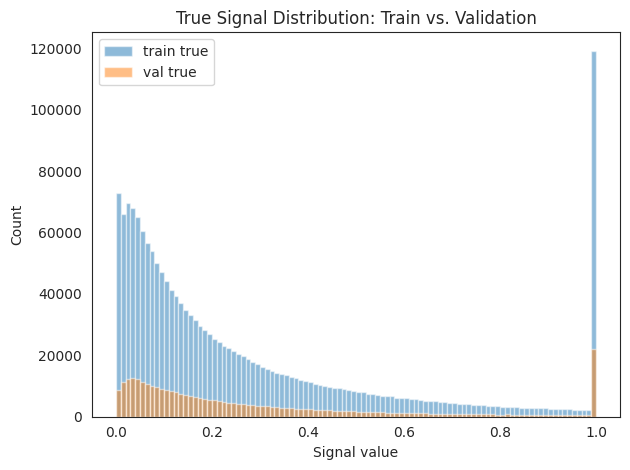

In [10]:
# Visualize the true‐signal distributions on train vs. validation
plt.hist(y_train, bins=100, alpha=0.5, label="train true")
plt.hist(y_val,   bins=100, alpha=0.5, label="val true")
plt.xlabel("Signal value")
plt.ylabel("Count")
plt.title("True Signal Distribution: Train vs. Validation")
plt.legend()
plt.tight_layout()
plt.show()


Training sees 3840 unique trading days per epoch.



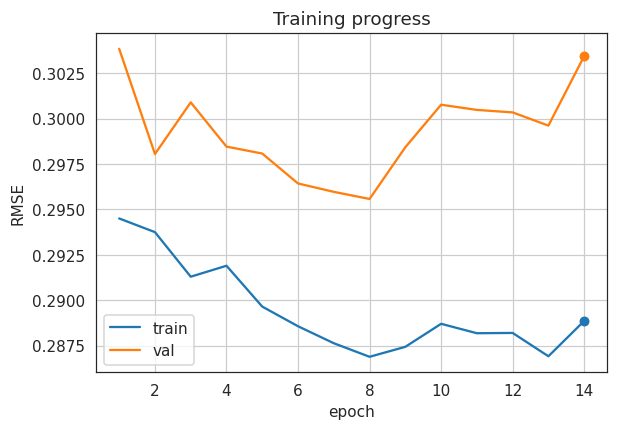

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ "R": RMSE=0.2945 MAE=0.2307 R2=-0.0298 | "B": Acc=0.7023 Prec=0.2809 Rec=0.0488 F1=0.0832 AUROC=0.5011
VALID→ "R": RMSE=0.3038 MAE=0.2067 R2=-0.1207 | "B": Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.5915


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ "R": RMSE=0.2937 MAE=0.2316 R2=-0.0246 | "B": Acc=0.6856 Prec=0.3008 Rec=0.1031 F1=0.1535 AUROC=0.5188
VALID→ "R": RMSE=0.2981 MAE=0.2050 R2=-0.0784 | "B": Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.5999


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ "R": RMSE=0.2913 MAE=0.2319 R2=-0.0075 | "B": Acc=0.6630 Prec=0.2938 Rec=0.1554 F1=0.2033 AUROC=0.5138
VALID→ "R": RMSE=0.3009 MAE=0.2040 R2=-0.0991 | "B": Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6036


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ "R": RMSE=0.2919 MAE=0.2317 R2=-0.0117 | "B": Acc=0.6749 Prec=0.2934 Rec=0.1245 F1=0.1748 AUROC=0.5148
VALID→ "R": RMSE=0.2985 MAE=0.2026 R2=-0.0814 | "B": Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6083


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ "R": RMSE=0.2896 MAE=0.2300 R2=0.0038 | "B": Acc=0.6723 Prec=0.2957 Rec=0.1335 F1=0.1840 AUROC=0.5158
VALID→ "R": RMSE=0.2981 MAE=0.2017 R2=-0.0786 | "B": Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6084


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ "R": RMSE=0.2886 MAE=0.2281 R2=0.0113 | "B": Acc=0.6803 Prec=0.2898 Rec=0.1074 F1=0.1568 AUROC=0.5101
VALID→ "R": RMSE=0.2964 MAE=0.2010 R2=-0.0667 | "B": Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6086


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ "R": RMSE=0.2876 MAE=0.2274 R2=0.0177 | "B": Acc=0.6875 Prec=0.2976 Rec=0.0953 F1=0.1443 AUROC=0.5132
VALID→ "R": RMSE=0.2960 MAE=0.2005 R2=-0.0634 | "B": Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6084


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ "R": RMSE=0.2869 MAE=0.2266 R2=0.0228 | "B": Acc=0.6909 Prec=0.2925 Rec=0.0827 F1=0.1290 AUROC=0.5113
VALID→ "R": RMSE=0.2956 MAE=0.2000 R2=-0.0606 | "B": Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6259


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ "R": RMSE=0.2874 MAE=0.2285 R2=0.0190 | "B": Acc=0.6916 Prec=0.2988 Rec=0.0852 F1=0.1326 AUROC=0.5157
VALID→ "R": RMSE=0.2984 MAE=0.2001 R2=-0.0811 | "B": Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6355


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ "R": RMSE=0.2887 MAE=0.2282 R2=0.0104 | "B": Acc=0.6941 Prec=0.3059 Rec=0.0833 F1=0.1309 AUROC=0.5208
VALID→ "R": RMSE=0.3008 MAE=0.2003 R2=-0.0981 | "B": Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6347


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ "R": RMSE=0.2882 MAE=0.2260 R2=0.0139 | "B": Acc=0.6968 Prec=0.3055 Rec=0.0755 F1=0.1211 AUROC=0.5215
VALID→ "R": RMSE=0.3005 MAE=0.2000 R2=-0.0960 | "B": Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6335


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ "R": RMSE=0.2882 MAE=0.2257 R2=0.0138 | "B": Acc=0.7001 Prec=0.3124 Rec=0.0701 F1=0.1146 AUROC=0.5226
VALID→ "R": RMSE=0.3003 MAE=0.1997 R2=-0.0950 | "B": Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6351


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ "R": RMSE=0.2869 MAE=0.2242 R2=0.0226 | "B": Acc=0.6975 Prec=0.3112 Rec=0.0770 F1=0.1235 AUROC=0.5243
VALID→ "R": RMSE=0.2996 MAE=0.1993 R2=-0.0898 | "B": Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6358


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ "R": RMSE=0.2889 MAE=0.2271 R2=0.0093 | "B": Acc=0.7023 Prec=0.3142 Rec=0.0646 F1=0.1071 AUROC=0.5244
VALID→ "R": RMSE=0.3034 MAE=0.2004 R2=-0.1178 | "B": Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6250
Early stopping at epoch 14

Champion validation RMSE = 0.295576
Improvement over zero‐baseline =  27.8%
Improvement over mean‐baseline =  -3.0%


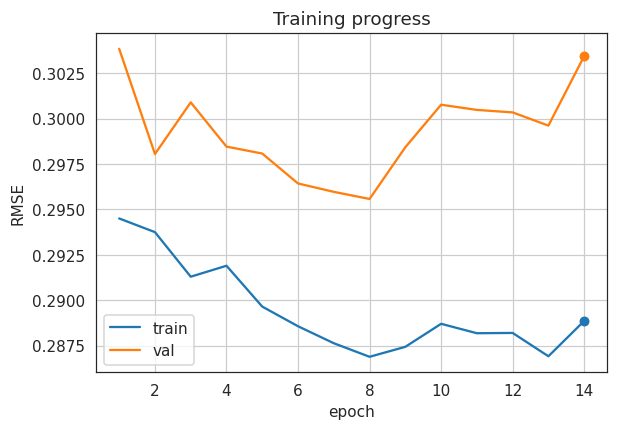

In [11]:
# How many unique trading days does each epoch see?
n_days = len(train_loader.dataset)
print(f"Training sees {n_days} unique trading days per epoch.\n")

# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = models.custom_stateful_training_loop(
    model               = model,
    optimizer           = optimizer,
    cosine_sched        = cosine_sched,
    plateau_sched       = plateau_sched,
    scaler              = scaler,
    train_loader        = train_loader,
    val_loader          = val_loader,
    max_epochs          = params.hparams['MAX_EPOCHS'],
    early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
    clipnorm            = clipnorm,
    device              = params.device
)

# -----------------------------------------------------------------------------
# Final reporting: best RMSE and relative improvement
# -----------------------------------------------------------------------------
print(f"\nChampion validation RMSE = {best_val_rmse:.6f}")

improvement_zero = 100.0 * (1.0 - best_val_rmse / rmse_zero_val)
print(f"Improvement over zero‐baseline = {improvement_zero:5.1f}%")

improvement_mean = 100.0 * (1.0 - best_val_rmse / rmse_mean_val)
print(f"Improvement over mean‐baseline = {improvement_mean:5.1f}%")

